In [1]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 
from matplotlib.ticker import MultipleLocator

#from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
from pylab import figure
#import seaborn as sns
#sns.set(style='white', context='poster', rc={'figure.figsize':(7,5)})

import pandas as pd
import csv
import numpy as np
import os 
import re 

import umap

from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import class_weight

from keras.models import load_model
from keras.utils.vis_utils import plot_model
from keras import initializers
from keras import regularizers
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import * # Keras is the most friendly Neural Network library, this Kernel use a lot of layers classes
from keras.models import Model
from keras import backend as K # The backend give us access to tensorflow operations and allow us to create the Attention class
from keras import optimizers # Allow us to access the Adam class to modify some parameters
from keras.callbacks import * # This object helps the model to train in a smarter way, avoiding overfitting

Using TensorFlow backend.
/home/julie/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/julie/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/julie/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/julie/anaconda3/lib/python3.7/site-packages/tensorflo

In [2]:
train = pd.read_csv("data/3Classes_train.csv", sep="\t")
valid = pd.read_csv("data/3Classes_valid.csv", sep="\t")

y_train = train["Global classifier2"]
y_valid = valid["Global classifier2"]

x_train = train["Sequence"].copy()
x_valid = valid["Sequence"].copy()

In [3]:
valid.head()

,Lead Protein ID,Global classifier2,Sequence,Sequence Lengh
0,Q96MN5,Mostly Organellar,MDKFVIRTPRIQNSPQKKDSGGKVYKQATIESLKRVVVVEDIKRWK...,208
1,P42575,Mostly Cytosolic,MAAPSAGSWSTFQHKELMAADRGRRILGVCGMHPHHQETLKKNRVV...,452
2,Q9NZP8,Mostly Organellar,MPGPRVWGKYLWRSPHSKGCPGAMWWLLLWGVLQACPTRGSVLLAQ...,487
3,Q96K80,Mostly Nuclear,MPDRDSYANGTGSSGGGPGGGGSEEASGAGVGSGGASSDAICRDFL...,434
4,Q86TA1,Mostly Cytosolic,MSIALKQVFNKDKTFRPKRKFEPGTQRFELHKRAQASLNSGVDLKA...,216


In [4]:
print(len(x_train), 'train sequences')
print(len(x_valid), 'test sequences')

4015 train sequences
709 test sequences


In [5]:
max_len = len(max(x_train, key=len))
print(max_len)

1500


In [6]:
# all amino acids (in blosum order)
aa = "*ARNDCQEGHILKMFPSTWYVU"
tot_aa = len(aa)

# define a mapping of aa to integers
aa_to_int = dict((c, i) for i, c in enumerate(aa))
int_to_aa = dict((i, c) for i, c in enumerate(aa))

## One hot encoding of Labels

In [7]:
cat = ['Mostly Cytosolic', 'Mostly Nuclear', 'Mostly Organellar']

tot_cat = len(cat)
cat_to_int = {}
int_to_cat = {}
for i in range(tot_cat):
    cat_to_int[cat[i]] = i
    int_to_cat[i] = cat[i]   

In [8]:
def cat_to_indices(Y):
    Y_indices = np.zeros([Y.shape[0],], dtype=int)
    for i in range(len(Y)):
        Y_indices[i] = cat_to_int[Y[i]]
    return Y_indices

# one hot encode
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)]
    return Y

In [9]:
y_train_indices = cat_to_indices(y_train)
y_valid_indices = cat_to_indices(y_valid)

y_train_OH = convert_to_one_hot(y_train_indices, C = tot_cat)
y_valid_OH = convert_to_one_hot(y_valid_indices, C = tot_cat)

## X_train processing: 
### From Sequences to list of indices

In [10]:
# Function to convert sequences to array of indices. I will that that one for embedding 

def seq_to_indices(X, aa_to_int, max_len):
    
    m = X.shape[0]                                   # number of training examples
    
    ### START CODE HERE ###
    # Initialize X_indices as a numpy matrix of zeros and the correct shape (≈ 1 line)
    X_indices = []
    
    for i in range(m):                               # loop over training examples
        seq_aa = X[i]
        seq_ind = []
        
        # Loop over the words of sentence_words
        for w in range(len(seq_aa)):
            seq_ind.append(aa_to_int[seq_aa[w]])
            
        X_indices.append(seq_ind)
            
    ### END CODE HERE ###
    
    return X_indices

In [11]:
x_train_indices = seq_to_indices(x_train, aa_to_int, max_len)
x_valid_indices = seq_to_indices(x_valid, aa_to_int, max_len)

In [12]:
# Pad sequences
# By default, the padding is added before the sequence
x_train_pad = sequence.pad_sequences(x_train_indices, maxlen=max_len, value=aa_to_int["*"])
x_valid_pad = sequence.pad_sequences(x_valid_indices, maxlen=max_len, value=aa_to_int["*"])
print('x_train shape:', x_train_pad.shape)
print('x_valid shape:', x_valid_pad.shape)

x_train shape: (4015, 1500)
x_valid shape: (709, 1500)


In [13]:
# One hot to label 
#Y is list of OH vector
def OH_to_label_indices(Y):
    labels = []
    for a in Y:
        indices = np.argmax(a)
        labels.append(indices)
    return labels

In [14]:
def indices_to_cat(Y):
    Y_cat = []
    for i in range(len(Y)):
        Y_cat.append(int_to_cat[Y[i]])
    return Y_cat

# First Model

A very simple implementation based on: 

https://www.youtube.com/watch?v=oaV_Fv5DwUM 

https://github.com/keras-team/keras/issues/4962 

This paper seems to use exactly that implementation: https://www.aclweb.org/anthology/P16-2034.pdf

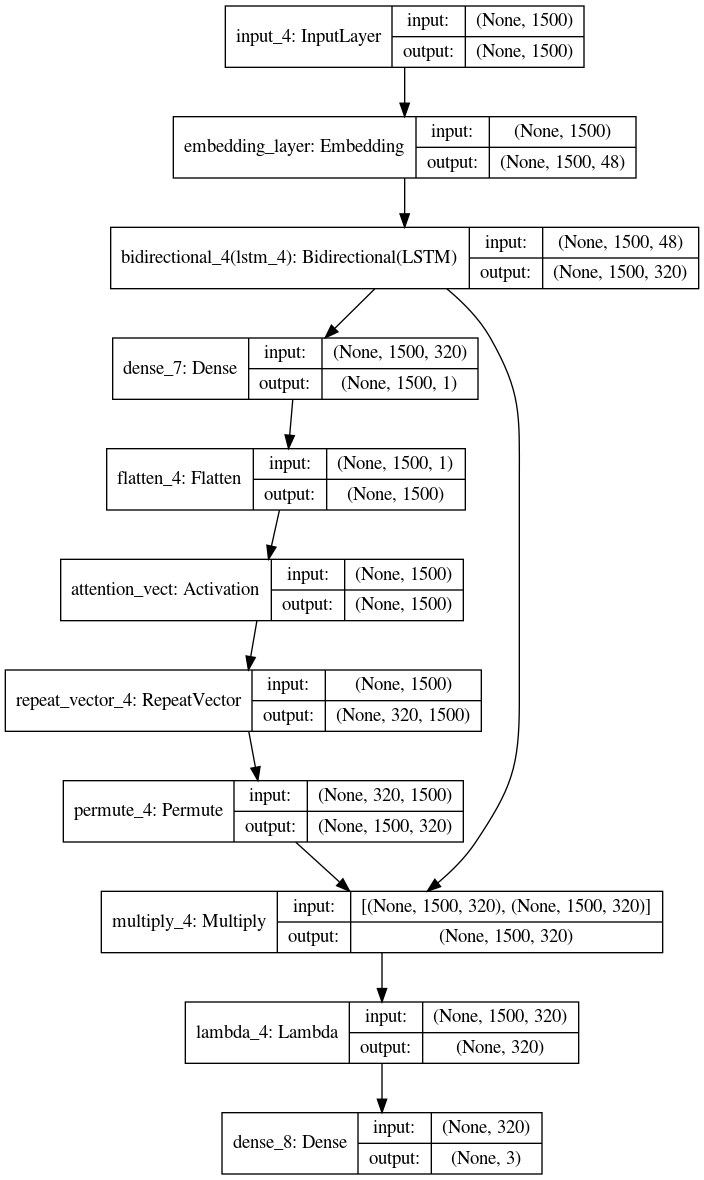

In [19]:
max_features = tot_aa
embedding_size = 48
units = 160

_input = Input(shape=[max_len], dtype='int32')

# get the embedding layer
embedded = Embedding(
        input_dim=max_features,
        output_dim=embedding_size,
        input_length=max_len,
        name = 'embedding_layer',
        trainable=True,
        mask_zero=False
    )(_input)

activations = Bidirectional(LSTM(units, return_sequences=True, 
                                 dropout=0.2, recurrent_dropout=0.2))(embedded)

# compute importance for each step
attention = Dense(1, activation='tanh')(activations)
attention = Flatten()(attention)
attention = Activation('softmax', name = 'attention_vect')(attention) # attention_vect for visualization
attention = RepeatVector(units*2)(attention)
attention = Permute([2, 1])(attention)
sent_representation = Multiply()([activations, attention])
sent_representation = Lambda(lambda xin: K.sum(xin, axis=-2), output_shape=(units*2,))(sent_representation)

probabilities = Dense(3, activation='softmax')(sent_representation)

class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
d_class_weights = dict(enumerate(class_weights))

model = Model(inputs=_input, outputs=probabilities)
model.compile('Nadam', 'categorical_crossentropy', metrics=['accuracy'])

plot_model(model, to_file= 'models_attention/model3_plot.png', show_shapes=True, show_layer_names=True)

In [20]:
ckpt = ModelCheckpoint(filepath='models_attention/weights_model3.hdf5', 
                           verbose=1, save_best_only=True)
# Train, train, train
history = model.fit(x_train_pad, y_train_OH, 
                    batch_size=64, epochs=50,
                    class_weight = class_weights,
          validation_data=[x_valid_pad, y_valid_OH], callbacks=[ckpt])

Train on 4015 samples, validate on 709 samples
Epoch 1/50
4015/4015 [==============================] - 471s 117ms/step - loss: 1.0434 - accuracy: 0.4565 - val_loss: 1.0337 - val_accuracy: 0.4739

Epoch 00001: val_loss improved from inf to 1.03369, saving model to models_attention/weights_model3.hdf5
Epoch 2/50
4015/4015 [==============================] - 468s 117ms/step - loss: 0.9599 - accuracy: 0.5006 - val_loss: 0.9583 - val_accuracy: 0.5063

Epoch 00002: val_loss improved from 1.03369 to 0.95827, saving model to models_attention/weights_model3.hdf5
Epoch 3/50
4015/4015 [==============================] - 419s 104ms/step - loss: 0.9560 - accuracy: 0.5076 - val_loss: 0.9279 - val_accuracy: 0.5219

Epoch 00003: val_loss improved from 0.95827 to 0.92790, saving model to models_attention/weights_model3.hdf5
Epoch 4/50
4015/4015 [==============================] - 440s 110ms/step - loss: 0.9237 - accuracy: 0.5253 - val_loss: 0.9366 - val_accuracy: 0.3992

Epoch 00004: val_loss did not impr


Epoch 00035: val_loss did not improve from 0.54532
Epoch 36/50
4015/4015 [==============================] - 453s 113ms/step - loss: 0.4776 - accuracy: 0.8199 - val_loss: 0.5587 - val_accuracy: 0.7842

Epoch 00036: val_loss did not improve from 0.54532
Epoch 37/50
4015/4015 [==============================] - 513s 128ms/step - loss: 0.4678 - accuracy: 0.8249 - val_loss: 0.5370 - val_accuracy: 0.7913

Epoch 00037: val_loss improved from 0.54532 to 0.53698, saving model to models_attention/weights_model3.hdf5
Epoch 38/50
4015/4015 [==============================] - 451s 112ms/step - loss: 0.5024 - accuracy: 0.8032 - val_loss: 0.5549 - val_accuracy: 0.7743

Epoch 00038: val_loss did not improve from 0.53698
Epoch 39/50
4015/4015 [==============================] - 417s 104ms/step - loss: 0.4981 - accuracy: 0.8070 - val_loss: 0.5556 - val_accuracy: 0.7842

Epoch 00039: val_loss did not improve from 0.53698
Epoch 40/50
4015/4015 [==============================] - 455s 113ms/step - loss: 0.476

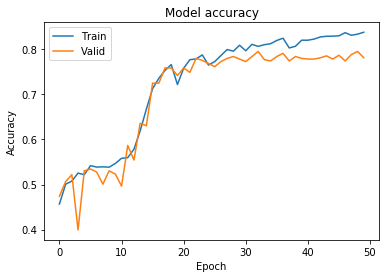

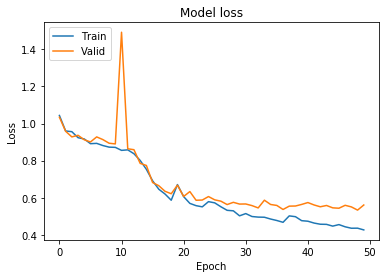

In [22]:
def history_plot(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Valid'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Valid'], loc='upper left')
    plt.show()
    
history_plot(history)

In [23]:
model = load_model('models_attention/weights_model3.hdf5')

In [24]:
model.evaluate(x_valid_pad, y_valid_OH)

709/709 [==============================] - 30s 42ms/step


[0.5335358718596661, 0.7954866290092468]

In [26]:
y_pred = model.predict(x_valid_pad)
y_pred_indices = OH_to_label_indices(y_pred)
y_pred_labels = indices_to_cat(y_pred_indices)

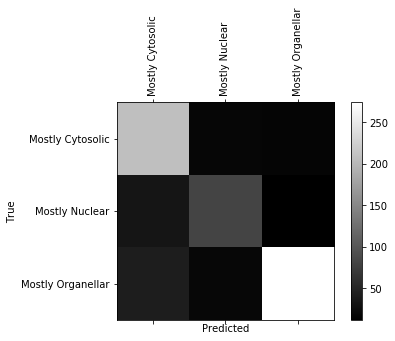

In [27]:
def confusion_plot(y_valid, y_pred_labels, cat):
    conf_mx = confusion_matrix(y_valid, y_pred_labels, labels=cat)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(conf_mx, cmap=plt.cm.gray)
    fig.colorbar(cax)
    ax.xaxis.set_major_locator(MultipleLocator(1))
    ax.yaxis.set_major_locator(MultipleLocator(1))
    ax.set_xticklabels([''] + cat,  rotation='vertical')
    ax.set_yticklabels([''] + cat)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
confusion_plot(y_valid, y_pred_labels, cat)

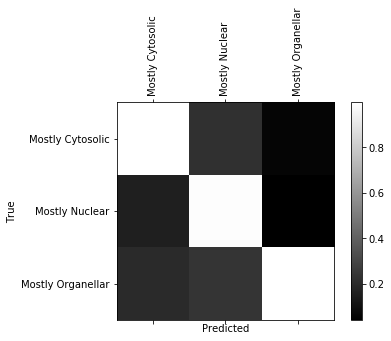

In [28]:
def confusion_plot_norm(y_valid, y_pred_labels, cat, axis=1):
    conf_mx = confusion_matrix(y_valid, y_pred_labels, labels=cat)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(conf_mx / (conf_mx.max(axis=axis)+1), cmap=plt.cm.gray)
    fig.colorbar(cax)
    ax.xaxis.set_major_locator(MultipleLocator(1))
    ax.yaxis.set_major_locator(MultipleLocator(1))
    ax.set_xticklabels([''] + cat,  rotation='vertical')
    ax.set_yticklabels([''] + cat)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    return(conf_mx)
conf = confusion_plot_norm(y_valid, y_pred_labels, cat, axis=1)

In [30]:
print(classification_report(y_valid, y_pred_labels))

                   precision    recall  f1-score   support

 Mostly Cytosolic       0.73      0.85      0.79       245
   Mostly Nuclear       0.68      0.64      0.66       128
Mostly Organellar       0.90      0.82      0.86       336

         accuracy                           0.80       709
        macro avg       0.77      0.77      0.77       709
     weighted avg       0.80      0.80      0.80       709



## Plot of the Embedding Layer

Good article about different dimension reduction techniques:
https://www.analyticsvidhya.com/blog/2018/08/dimensionality-reduction-techniques-python/

In [31]:
embedding = model.get_layer('embedding_layer').get_weights()
embedding = embedding[0]
embedding.shape

(22, 48)

In [33]:
def plot_embedding(embedding, aa):
    fig, ax = plt.subplots()
    plt.scatter(embedding[:, 0], embedding[:, 1], edgecolor='none')
    aaL = list(aa)
    for i in range(len(aaL)):
        ax.annotate(aaL[i], (embedding[:, 0][i], embedding[:, 1][i]))
    
    plt.show()

### t-SNE plot

t-distributed stochastic neighbor embedding

Doc for tSNE: https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

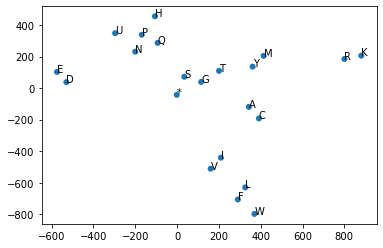

In [55]:
# tSNE plots of Embedding 
tSNE = TSNE(n_components=2, perplexity=4)
embedding_tSNE = tSNE.fit_transform(embedding)

#print("original shape:   ", embedding.shape)
#print("transformed shape:", embedding_tSNE.shape)

# NB: perplexity plays a huge role there, 
#since our number of feature is very small I should use a very small value (between 2 and 7).
plot_embedding(embedding_tSNE, aa)

## Plot the attention layer

I need some serious work on that one 

In [51]:
model = Model(inputs=model.input,
              outputs=[model.output, model.get_layer('attention_vect').output])
outputs = model.predict(x_valid_pad)
model_outputs = outputs[0]
attention_outputs = outputs[1]

/home/julie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


Text(0, 0.5, 'Attention Distribution')

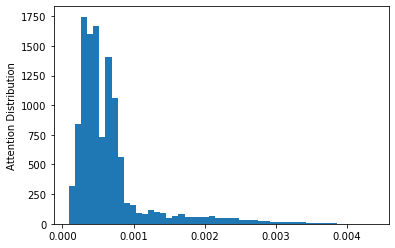

In [52]:
attention_distrib = np.concatenate( attention_outputs, axis=0 )
plt.hist(attention_distrib, normed=True, bins=50)
plt.ylabel('Attention Distribution')

/home/julie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """


Text(0.5, 1.0, 'All proteins attention values distribution (no pad)')

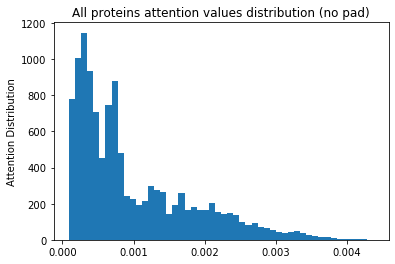

In [57]:
attention_nopad = []
for x in range(len(attention_outputs)):
    attention_nopad.append(attention_outputs[x][1500-len(x_valid[x]):]) 
attention_nopad_distrib = np.concatenate( attention_nopad, axis=0 )
plt.hist(attention_nopad_distrib, normed=True, bins=50)
plt.ylabel('Attention Distribution')
plt.title('All proteins attention values distribution (no pad)')

/home/julie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """


Text(0.5, 1.0, 'Attention values distribution for padding')

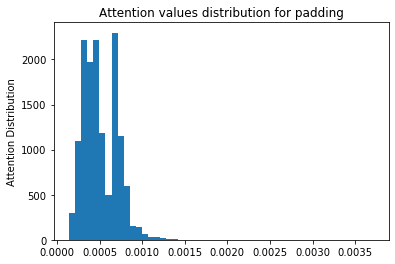

In [58]:
pad = []
for x in range(len(attention_outputs)):
    pad.append(attention_outputs[x][0:(1500-len(x_valid[x]))])
pad_distrib = np.concatenate( pad, axis=0 )
plt.hist(pad_distrib, normed=True, bins=50)
plt.ylabel('Attention Distribution')
plt.title('Attention values distribution for padding')

/home/julie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """


Text(0, 0.5, 'Attention Distribution')

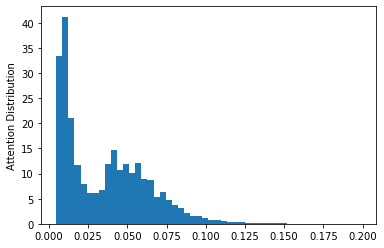

In [63]:
norm_pad = []
for seq in pad:
    norm_pad.append(seq / np.linalg.norm(seq))
attention_distrib = np.concatenate( norm_nopad_attention, axis=0 )
plt.hist(attention_distrib, normed=True, bins=50)
plt.ylabel('Attention Distribution')

Ok... In that specific model, I got very weird bimodal distributions for attentions values, even in padding (although the values of zero padding are quite small). I don't like it. when you do normalize pad and proteins attention values separately, you and up with the same distribution. 

In [61]:
# Normalize attention values 
norm_nopad_attention = []
for seq in attention_nopad:
    norm_nopad_attention.append(seq / np.linalg.norm(seq))

/home/julie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


Text(0, 0.5, 'Attention Distribution')

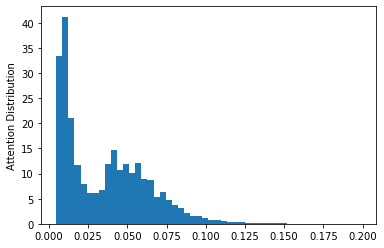

In [62]:
attention_distrib = np.concatenate( norm_nopad_attention, axis=0 )
plt.hist(attention_distrib, normed=True, bins=50)
plt.ylabel('Attention Distribution')

### Normalize then split pad / protein

/home/julie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  import sys


Text(0, 0.5, 'Attention Distribution')

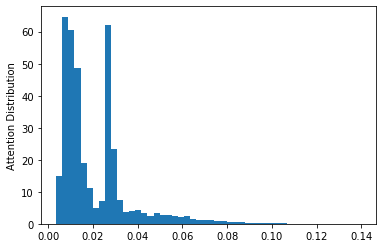

In [64]:
# Normalize attention values 
norm_attention = []
for seq in attention_outputs:
    norm_attention.append(seq / np.linalg.norm(seq))
    
attention_distrib = np.concatenate( norm_attention, axis=0 )
plt.hist(attention_distrib, normed=True, bins=50)
plt.ylabel('Attention Distribution')

In [70]:
pad_norm = []
prot_norm = []
for x in range(len(norm_attention)):
    pad_norm.append(norm_attention[x][0:(1500-len(x_valid[x]))])
    prot_norm.append(norm_attention[x][1500-len(x_valid[x]):]) 

/home/julie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


Text(0.5, 1.0, 'Proteins attention values distribution')

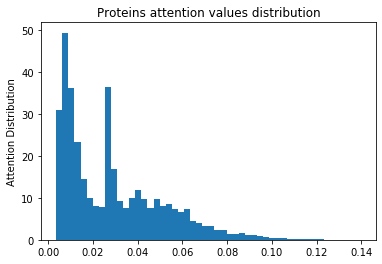

In [67]:
attention_distrib = np.concatenate( prot_norm, axis=0 )
plt.hist(attention_distrib, normed=True, bins=50)
plt.ylabel('Attention Distribution')
plt.title('Proteins attention values distribution')

/home/julie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


Text(0.5, 1.0, 'pad attention values distribution')

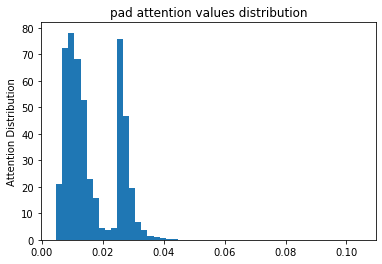

In [71]:
attention_distrib = np.concatenate( pad_norm, axis=0 )
plt.hist(attention_distrib, normed=True, bins=50)
plt.ylabel('Attention Distribution')
plt.title('pad attention values distribution')

Ok, that model attention behave worse than previous model. run a new one. 

### Check attention for a single protein sequence

In [72]:
def indices_to_seq(X):
    seq = ''
    for i in range(len(X)):
        seq += int_to_aa[X[i]] 
    return seq

In [75]:
# I don't fully understand that code
# the color_charvals function doesn't work that well because my vector is big
# and the values are very small, I need a better function

class CharVal(object):
    def __init__(self, char, val):
        self.char = char
        self.val = val

    def __str__(self):
        return self.char

def rgb_to_hex(rgb):
    return '#%02x%02x%02x' % rgb

def color_charvals(s):
    r = 0
    if s.val < 0.025:
        r = 255
    elif s.val > 0.045:
        r = 0
    else:
        r = 255*(1 - (s.val)*10)
    r = int(r)
    color = rgb_to_hex((255, r, 255))
    return 'background-color: %s' % color
    
    #r = int(255/(s.val*10 +1))
    #color = rgb_to_hex((r, r, r))
    #return 'background-color: %s' % color

In [76]:
X = 6

attention = prot_norm[X]
# match each aa and attention
char_vals = [CharVal(c, v) for c, v in 
             zip(x_valid[X], attention)]

char_df = pd.DataFrame(char_vals).transpose()
# apply coloring values
char_df = char_df.style.applymap(color_charvals)
char_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577
0,M,P,F,R,L,L,I,P,L,G,L,L,C,A,L,L,P,Q,H,H,G,A,P,G,P,D,G,S,A,P,D,P,A,H,Y,R,E,R,V,K,A,M,F,Y,H,A,Y,D,S,Y,L,E,N,A,F,P,F,D,E,L,R,P,L,T,C,D,G,H,D,T,W,G,S,F,S,L,T,L,I,D,A,L,D,T,L,L,I,L,G,N,V,S,E,F,Q,R,V,V,E,V,L,Q,D,S,V,D,F,D,I,D,V,N,A,S,V,F,E,T,N,I,R,V,V,G,G,L,L,S,A,H,L,L,S,K,K,A,G,V,E,V,E,A,G,W,P,C,S,G,P,L,L,R,M,A,E,E,A,A,R,K,L,L,P,A,F,Q,T,P,T,G,M,P,Y,G,T,V,N,L,L,H,G,V,N,P,G,E,T,P,V,T,C,T,A,G,I,G,T,F,I,V,E,F,A,T,L,S,S,L,T,G,D,P,V,F,E,D,V,A,R,V,A,L,M,R,L,W,E,S,R,S,D,I,G,L,V,G,N,H,I,D,V,L,T,G,K,W,V,A,Q,D,A,G,I,G,A,G,V,D,S,Y,F,E,Y,L,V,K,G,A,I,L,L,Q,D,K,K,L,M,A,M,F,L,E,Y,N,K,A,I,R,N,Y,T,R,F,D,D,W,Y,L,W,V,Q,M,Y,K,G,T,V,S,M,P,V,F,Q,S,L,E,A,Y,W,P,G,L,Q,S,L,I,G,D,I,D,N,A,M,R,T,F,L,N,Y,Y,T,V,W,K,Q,F,G,G,L,P,E,F,Y,N,I,P,Q,G,Y,T,V,E,K,R,E,G,Y,P,L,R,P,E,L,I,E,S,A,M,Y,L,Y,R,A,T,G,D,P,T,L,L,E,L,G,R,D,A,V,E,S,I,E,K,I,S,K,V,E,C,G,F,A,T,I,K,D,L,R,D,H,K,L,D,N,R,M,E,S,F,F,L,A,E,T,V,K,Y,L,Y,L,L,F,D,P,T,N,F,I,H,N,N,G,S,T,F,D,A,V,I,T,P,Y,G,E,C,I,L,G,A,G,G,Y,I,F,N,T,E,A,H,P,I,D,P,A,A,L,H,C,C,Q,R,L,K,E,E,Q,W,E,V,E,D,L,M,R,E,F,Y,S,L,K,R,S,R,S,K,F,Q,K,N,T,V,S,S,G,P,W,E,P,P,A,R,P,G,T,L,F,S,P,E,N,H,D,Q,A,R,E,R,K,P,A,K,Q,K,V,P,L,L,S,C,P,S,Q,P,F,T,S,K,L,A,L,L,G,Q,V,F,L,D,S,S


In [77]:
print(y_valid[X])
print(valid['Lead Protein ID'][X])
print(y_pred_labels[X])

Mostly Organellar
Q9BV94
Mostly Organellar


## Select the 'nb_max' maximum attention weights values position through all proteins from the valid dataset and Visualisation

Then, Compare motifs identified to this site: http://elm.eu.org/combined_search?query=NLS

In [81]:
# Number of highest values to select
nb_max = 50
max_att_indexes = []
for seq in prot_norm:
    max_att_indexes.append(np.sort(np.argpartition(seq, -nb_max)[-nb_max:]))

In [82]:
X = 6

def color_charvals(s):
    r = 255-int(s.val*255)
    color = rgb_to_hex((255,255 , r))
    return 'background-color: %s' % color

max_ind = max_att_indexes[X]
max_vect = np.zeros(len(x_valid[X]))
for val in max_ind:
    max_vect[val] = 1
# match each aa and attention
char_vals = [CharVal(c, v) for c, v in 
             zip(x_valid[X], max_vect)]

char_df = pd.DataFrame(char_vals).transpose()
# apply coloring values
char_df = char_df.style.applymap(color_charvals)
char_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577
0,M,P,F,R,L,L,I,P,L,G,L,L,C,A,L,L,P,Q,H,H,G,A,P,G,P,D,G,S,A,P,D,P,A,H,Y,R,E,R,V,K,A,M,F,Y,H,A,Y,D,S,Y,L,E,N,A,F,P,F,D,E,L,R,P,L,T,C,D,G,H,D,T,W,G,S,F,S,L,T,L,I,D,A,L,D,T,L,L,I,L,G,N,V,S,E,F,Q,R,V,V,E,V,L,Q,D,S,V,D,F,D,I,D,V,N,A,S,V,F,E,T,N,I,R,V,V,G,G,L,L,S,A,H,L,L,S,K,K,A,G,V,E,V,E,A,G,W,P,C,S,G,P,L,L,R,M,A,E,E,A,A,R,K,L,L,P,A,F,Q,T,P,T,G,M,P,Y,G,T,V,N,L,L,H,G,V,N,P,G,E,T,P,V,T,C,T,A,G,I,G,T,F,I,V,E,F,A,T,L,S,S,L,T,G,D,P,V,F,E,D,V,A,R,V,A,L,M,R,L,W,E,S,R,S,D,I,G,L,V,G,N,H,I,D,V,L,T,G,K,W,V,A,Q,D,A,G,I,G,A,G,V,D,S,Y,F,E,Y,L,V,K,G,A,I,L,L,Q,D,K,K,L,M,A,M,F,L,E,Y,N,K,A,I,R,N,Y,T,R,F,D,D,W,Y,L,W,V,Q,M,Y,K,G,T,V,S,M,P,V,F,Q,S,L,E,A,Y,W,P,G,L,Q,S,L,I,G,D,I,D,N,A,M,R,T,F,L,N,Y,Y,T,V,W,K,Q,F,G,G,L,P,E,F,Y,N,I,P,Q,G,Y,T,V,E,K,R,E,G,Y,P,L,R,P,E,L,I,E,S,A,M,Y,L,Y,R,A,T,G,D,P,T,L,L,E,L,G,R,D,A,V,E,S,I,E,K,I,S,K,V,E,C,G,F,A,T,I,K,D,L,R,D,H,K,L,D,N,R,M,E,S,F,F,L,A,E,T,V,K,Y,L,Y,L,L,F,D,P,T,N,F,I,H,N,N,G,S,T,F,D,A,V,I,T,P,Y,G,E,C,I,L,G,A,G,G,Y,I,F,N,T,E,A,H,P,I,D,P,A,A,L,H,C,C,Q,R,L,K,E,E,Q,W,E,V,E,D,L,M,R,E,F,Y,S,L,K,R,S,R,S,K,F,Q,K,N,T,V,S,S,G,P,W,E,P,P,A,R,P,G,T,L,F,S,P,E,N,H,D,Q,A,R,E,R,K,P,A,K,Q,K,V,P,L,L,S,C,P,S,Q,P,F,T,S,K,L,A,L,L,G,Q,V,F,L,D,S,S


So... Now I need to look for NLS in valid set and check whether attention catch all of them by comparing sequence indices from max attention

## Get regions deemed important by the attention layer  into the Dataframe

In [36]:
motifs_loc = []
motifs = []
stop = 0
for l in max_att_nopad:
    start = l[0]
    for i in range(1,len(l)):
        if l[i-1] + 3 >= l[i]:
            stop = l[i]
        else:
            if start < stop:
                motifs.append((start, stop))
            start = l[i]
    if start < stop:
        motifs.append((start, stop))
    motifs_loc.append(motifs)
    motifs = []


In [37]:
motifs_aa = []
motifs = []
for i in range(len(motifs_loc)):
    seq = x_valid[i]
    m = motifs_loc[i]
    for tup in m:
        motifs.append(seq[tup[0]:tup[1]+1])
    motifs_aa.append(motifs)
    motifs = []

In [41]:
valid["Model Prediction"] = y_pred_labels

In [39]:
valid["Motifs"] = motifs_aa
valid["Motifs Localization"] = motifs_loc

In [40]:
valid['Motifs']

0      [QNSPQKKDSGG, ELPD, ELKKKIPSREVLKSTRIGH, DSE, ...
1      [ELMAADRGRRILGVCGMHPHHQETLKKNRVVLAKQLLLSELLEHL...
2      [RVWGKYLWRSPHSKGCPGAMWWLLLWGVL, LLAQE, EN, DRQ...
3      [RNVCKRGKRCRYRHPDMSE, NEFIFCHDFQNKE, KEDEDGY, ...
4      [KQVFNKDKTFRPKRKFEPGTQRFELHKRAQASLNSGVDLKAAVQL...
                             ...                        
704    [LGGGGEAR, LGS, EDCDCAQDENCK, DRDSRCNL, CDGLE,...
705    [AKDGLQQSKCPDTTP, DAE, PEE, LAE, LSE, EE, EE, ...
706    [IDAD, EPD, ITPL, HSEHVGLDNDLREKYMQE, QD, LRCE...
707    [CT, VMD, ALNGFGGMC, IQ, RAFAFT, LVGFGVTCLIPNL...
708    [VYMIRVYLLQGWYIVTYALGIYHLNLFIAFLSPKVD, ED, VCT...
Name: Motifs, Length: 709, dtype: object

### Description of ELM Regex
http://elm.eu.org/infos/help.html

Regular expression usefull links:
https://www.debuggex.com/cheatsheet/regex/python
https://regex101.com/#python

In [19]:
NLS_regex = ['[KR][KR].{7,15}[^DE]((K[RK])|(RK))(([^DE][KR])|([KR][^DE]))[^DE]',
             '[^DE]((K[RK])|(RK))[KRP][KR][^DE]',
             '[^DE]((K[RK])|(RK))(([^DE][KR])|([KR][^DE]))(([PKR])|([^DE][DE]))',
             '(([PKR].{0,1}[^DE])|([PKR]))((K[RK])|(RK))(([^DE][KR])|([KR][^DE]))[^DE]']

NES_regex = ['([DEQ].{0,1}[LIM].{2,3}[LIVMF][^P]{2,3}[LMVF].[LMIV].{0,3}[DE])|([DE].{0,1}[LIM].{2,3}[LIVMF][^P]{2,3}[LMVF].[LMIV].{0,3}[DEQ])']

In [74]:
NLS_valid = []
NLS_nb = 0 # count seq with NLS
NLS_bool = []
for seq in x_valid:
    NLS = []
    for motifs in NLS_regex:
        match = re.finditer(motifs, seq)
        if match:
            for m in match:
                NLS.append((m.start(), m.end()))
    if NLS != []:
        NLS_bool.append(True)
        NLS.sort(key=lambda tup: tup[1])
        NLS_nb +=1
    else:
        NLS_bool.append(False)
    NLS_valid.append(NLS)
                

In [21]:
print(str(NLS_nb/len(x_valid)*100) + '% of proteins in valid set have at least one NLS motifs')

41.18476727785614% of proteins in valid set have at least one NLS motifs


In [22]:
valid["NLS"] = NLS_bool

In [23]:
valid["NLS positions"] = NLS_valid

In [60]:
def isintersect(a, b):
    for a0 in a:
        for b0 in b:
            if ((b0[0] <= a0[0] and a0[0] < b0[1]) or (a0[0] <= b0[0] and b0[0] < a0[1])):
                return True
    return False
    #
    #a0 = [(i[0], i[1], 0) for i in a]
    #b0 = [(i[0], i[1], 1) for i in b]
    #c = sorted(a0+b0, key=lambda i: i[0])
    #for i in range(len(c)):
    #    j = i+1
    #    while j != len(c) and c[i][1] > c[j][0]:
    #        if (c[i][2] != c[j][2]):
    #            return True
    #        j=j+1
    #return False

assert(isintersect([(0,10)], [(5, 15)])==True)
assert(isintersect([(0,10)], [(10, 20)])==False)
assert(isintersect([(0,10),(20,30)], [(10, 20), (30, 40)])==False)
assert(isintersect([(0,10),(20,30)], [(10, 25), (30, 40)])==True)

In [76]:
NLS_intersect = []
for i in range(len(motifs_loc)):
    NLS_intersect.append(isintersect(motifs_loc[i],NLS_valid[i]))

In [78]:
valid["NLS/Attention Intersect"] = NLS_intersect

In [79]:
valid.groupby(["Global classifier2", "NLS/Attention Intersect"]).count()/valid.groupby("Global classifier2").count()

Lead Protein ID  Model Prediction  \
Global classifier2 NLS/Attention Intersect                                      
Mostly Cytosolic   False                           0.775510          0.775510   
                   True                            0.224490          0.224490   
Mostly Nuclear     False                           0.289062          0.289062   
                   True                            0.710938          0.710938   
Mostly Organellar  False                           0.818452          0.818452   
                   True                            0.181548          0.181548   

                                              Motifs  Motifs Localization  \
Global classifier2 NLS/Attention Intersect                                  
Mostly Cytosolic   False                    0.775510             0.775510   
                   True                     0.224490             0.224490   
Mostly Nuclear     False                    0.289062             0.289062   
                   True                     0.710938             0.710938   
Mostly Organellar  False                    0.818452             0.818452   
                   True                     0.181548             0.181548   

                                                 NES  NES positions       NLS  \
Global classifier2 NLS/Attention Intersect                                      
Mostly Cytosolic   False                    0.775510       0.775510  0.775510   
                   True                     0.224490       0.224490  0.224490   
Mostly Nuclear     False                    0.289062       0.289062  0.289062   
                   True                     0.710938       0.710938  0.710938   
Mostly Organellar  False                    0.818452       0.818452  0.818452   
                   True                     0.181548       0.181548  0.181548   

                                            NLS positions  \
Global classifier2 NLS/Attention Intersect                  
Mostly Cytosolic   False                         0.775510   
                   True                          0.224490   
Mostly Nuclear     False                         0.289062   
                   True                          0.710938   
Mostly Organellar  False                         0.818452   
                   True                          0.181548   

                                            NLS/Attention Intersect  Sequence  \
Global classifier2 NLS/Attention Intersect                                      
Mostly Cytosolic   False                                        NaN  0.775510   
                   True                                         NaN  0.224490   
Mostly Nuclear     False                                        NaN  0.289062   
                   True                                         NaN  0.710938   
Mostly Organellar  False                                        NaN  0.818452   
                   True                                         NaN  0.181548   

                                            Sequence Lengh  
Global classifier2 NLS/Attention Intersect                  
Mostly Cytosolic   False                          0.775510  
                   True                           0.224490  
Mostly Nuclear     False                          0.289062  
                   True                           0.710938  
Mostly Organellar  False                          0.818452  
                   True                           0.181548

In [69]:
isintersect(motifs_loc[0],NLS_valid[0])

True

In [45]:
Nuclear = valid.loc[valid['Global classifier2'] == 'Mostly Nuclear']
Nuclear.head()

,Lead Protein ID,Global classifier2,Sequence,Sequence Lengh,NLS,NLS positions,Model Prediction,Motifs,Motifs Localization
3,Q96K80,Mostly Nuclear,MPDRDSYANGTGSSGGGPGGGGSEEASGAGVGSGGASSDAICRDFL...,434,True,"[(49, 55), (50, 58), (206, 212), (204, 212)]",Mostly Cytosolic,"[RNVCKRGKRCRYRHPDMSE, NEFIFCHDFQNKE, KEDEDGY, ...","[(46, 64), (73, 85), (98, 104), (187, 196), (2..."
15,Q92802,Mostly Nuclear,MSYGEIEGKFLGPREEVTSEPRCKKLKSTTESYVFHNHSNADFHRI...,583,True,"[(20, 28)]",Mostly Cytosolic,[DFHRIQEKTGNDWVPVTIIDVRGHSYLQENKIKTTDLHRPLHDEM...,"[(41, 420), (91, 420), (127, 133), (137, 151),..."
16,Q8NEY8,Mostly Nuclear,MWSEGRYEYERIPRERAPPRSHPSDGYNRLVNIVPKKPPLLDRPGE...,458,True,"[(387, 393), (388, 394), (387, 395)]",Mostly Nuclear,[DRPGEGSYNRYYSHVDYRDYDEGRSFSHDRRSGPPHRGDESGYRW...,"[(41, 561), (45, 561), (56, 61), (79, 80), (88..."
18,O75151,Mostly Nuclear,MATVPVYCVCRLPYDVTRFMIECDACKDWFHGSCVGVEEEEAPDID...,1096,True,"[(61, 67), (62, 68), (488, 494), (486, 494), (...",Mostly Nuclear,"[PKTVKMPKPSKIPKPPKPPKPPRPPKTLKLKDGGKK, DD, KKK...","[(493, 528), (899, 900), (950, 956), (1050, 10..."
25,Q8N9R8,Mostly Nuclear,MVRGARQPQQPRSRLAPRLTGTVEKPPRKRRSRTEFALKEIMSSGG...,606,True,"[(26, 32), (24, 32), (27, 33)]",Mostly Organellar,"[QQPR, EKP, SGGAEDD, DLPQ, DN, DE, RENPHK, EMH...","[(8, 11), (23, 25), (43, 49), (77, 80), (112, ..."


In [44]:
valid.head()

,Lead Protein ID,Global classifier2,Sequence,Sequence Lengh,NLS,NLS positions,Model Prediction,Motifs,Motifs Localization
0,Q96MN5,Mostly Organellar,MDKFVIRTPRIQNSPQKKDSGGKVYKQATIESLKRVVVVEDIKRWK...,208,True,"[(65, 71)]",Mostly Nuclear,"[QNSPQKKDSGG, ELPD, ELKKKIPSREVLKSTRIGH, DSE, ...","[(11, 21), (49, 52), (64, 82), (92, 94), (140,..."
1,P42575,Mostly Cytosolic,MAAPSAGSWSTFQHKELMAADRGRRILGVCGMHPHHQETLKKNRVV...,452,True,"[(23, 45), (148, 156)]",Mostly Cytosolic,[ELMAADRGRRILGVCGMHPHHQETLKKNRVVLAKQLLLSELLEHL...,"[(15, 207), (20, 207), (37, 207), (51, 63), (9..."
2,Q9NZP8,Mostly Organellar,MPGPRVWGKYLWRSPHSKGCPGAMWWLLLWGVLQACPTRGSVLLAQ...,487,True,"[(406, 412)]",Mostly Organellar,"[RVWGKYLWRSPHSKGCPGAMWWLLLWGVL, LLAQE, EN, DRQ...","[(4, 32), (42, 46), (145, 146), (217, 223), (4..."
3,Q96K80,Mostly Nuclear,MPDRDSYANGTGSSGGGPGGGGSEEASGAGVGSGGASSDAICRDFL...,434,True,"[(49, 55), (50, 58), (206, 212), (204, 212)]",Mostly Cytosolic,"[RNVCKRGKRCRYRHPDMSE, NEFIFCHDFQNKE, KEDEDGY, ...","[(46, 64), (73, 85), (98, 104), (187, 196), (2..."
4,Q86TA1,Mostly Cytosolic,MSIALKQVFNKDKTFRPKRKFEPGTQRFELHKRAQASLNSGVDLKA...,216,False,[],Mostly Cytosolic,[KQVFNKDKTFRPKRKFEPGTQRFELHKRAQASLNSGVDLKAAVQL...,"[(5, 271), (9, 17), (25, 28), (35, 37), (50, 5..."


In [47]:
valid.groupby(["Global classifier2", "NLS"]).count()/valid.groupby("Global classifier2").count()

Lead Protein ID  Model Prediction    Motifs  \
Global classifier2 NLS                                                  
Mostly Cytosolic   False         0.657143          0.657143  0.657143   
                   True          0.342857          0.342857  0.342857   
Mostly Nuclear     False         0.179688          0.179688  0.179688   
                   True          0.820312          0.820312  0.820312   
Mostly Organellar  False         0.693452          0.693452  0.693452   
                   True          0.306548          0.306548  0.306548   

                          Motifs Localization  NLS  NLS positions  Sequence  \
Global classifier2 NLS                                                        
Mostly Cytosolic   False             0.657143  NaN       0.657143  0.657143   
                   True              0.342857  NaN       0.342857  0.342857   
Mostly Nuclear     False             0.179688  NaN       0.179688  0.179688   
                   True              0.820312  NaN       0.820312  0.820312   
Mostly Organellar  False             0.693452  NaN       0.693452  0.693452   
                   True              0.306548  NaN       0.306548  0.306548   

                          Sequence Lengh  
Global classifier2 NLS                    
Mostly Cytosolic   False        0.657143  
                   True         0.342857  
Mostly Nuclear     False        0.179688  
                   True         0.820312  
Mostly Organellar  False        0.693452  
                   True         0.306548

### Same thing with NES

In [80]:
NES_valid = []
NES_nb = 0 # count seq with NLS
NES_bool = []
for seq in x_valid:
    NES = []
    for motifs in NES_regex:
        match = re.finditer(motifs, seq)
        if match:
            for m in match:
                NES.append((m.start(), m.end()))
    if NES != []:
        NES_bool.append(True)
        NES.sort(key=lambda tup: tup[1])
        NES_nb +=1
    else:
        NES_bool.append(False)
    NES_valid.append(NES)

In [81]:
print(str(NES_nb/len(x_valid)*100) + '% of proteins in valid set have at least one NES motifs')

34.27362482369535% of proteins in valid set have at least one NES motifs


In [82]:
valid["NES"] = NES_bool
valid["NES positions"] = NES_valid
valid.head()

,Lead Protein ID,Global classifier2,Sequence,Sequence Lengh,NLS,NLS positions,Model Prediction,Motifs,Motifs Localization,NES,NES positions,NLS/Attention Intersect
0,Q96MN5,Mostly Organellar,MDKFVIRTPRIQNSPQKKDSGGKVYKQATIESLKRVVVVEDIKRWK...,208,True,"[(65, 71)]",Mostly Nuclear,"[QNSPQKKDSGG, ELPD, ELKKKIPSREVLKSTRIGH, DSE, ...","[(11, 21), (49, 52), (64, 82), (92, 94), (140,...",True,"[(140, 156)]",True
1,P42575,Mostly Cytosolic,MAAPSAGSWSTFQHKELMAADRGRRILGVCGMHPHHQETLKKNRVV...,452,True,"[(23, 45), (148, 156)]",Mostly Cytosolic,[ELMAADRGRRILGVCGMHPHHQETLKKNRVVLAKQLLLSELLEHL...,"[(15, 207), (20, 207), (37, 207), (51, 63), (9...",False,[],True
2,Q9NZP8,Mostly Organellar,MPGPRVWGKYLWRSPHSKGCPGAMWWLLLWGVLQACPTRGSVLLAQ...,487,True,"[(406, 412)]",Mostly Organellar,"[RVWGKYLWRSPHSKGCPGAMWWLLLWGVL, LLAQE, EN, DRQ...","[(4, 32), (42, 46), (145, 146), (217, 223), (4...",False,[],False
3,Q96K80,Mostly Nuclear,MPDRDSYANGTGSSGGGPGGGGSEEASGAGVGSGGASSDAICRDFL...,434,True,"[(49, 55), (50, 58), (206, 212), (204, 212)]",Mostly Cytosolic,"[RNVCKRGKRCRYRHPDMSE, NEFIFCHDFQNKE, KEDEDGY, ...","[(46, 64), (73, 85), (98, 104), (187, 196), (2...",True,"[(61, 75)]",True
4,Q86TA1,Mostly Cytosolic,MSIALKQVFNKDKTFRPKRKFEPGTQRFELHKRAQASLNSGVDLKA...,216,False,[],Mostly Cytosolic,[KQVFNKDKTFRPKRKFEPGTQRFELHKRAQASLNSGVDLKAAVQL...,"[(5, 271), (9, 17), (25, 28), (35, 37), (50, 5...",False,[],False


In [52]:
valid.groupby(["Global classifier2", "NES"]).count()/valid.groupby("Global classifier2").count()

Lead Protein ID  Model Prediction    Motifs  \
Global classifier2 NES                                                  
Mostly Cytosolic   False         0.595918          0.595918  0.595918   
                   True          0.404082          0.404082  0.404082   
Mostly Nuclear     False         0.648438          0.648438  0.648438   
                   True          0.351562          0.351562  0.351562   
Mostly Organellar  False         0.705357          0.705357  0.705357   
                   True          0.294643          0.294643  0.294643   

                          Motifs Localization  NES  NES positions       NLS  \
Global classifier2 NES                                                        
Mostly Cytosolic   False             0.595918  NaN       0.595918  0.595918   
                   True              0.404082  NaN       0.404082  0.404082   
Mostly Nuclear     False             0.648438  NaN       0.648438  0.648438   
                   True              0.351562  NaN       0.351562  0.351562   
Mostly Organellar  False             0.705357  NaN       0.705357  0.705357   
                   True              0.294643  NaN       0.294643  0.294643   

                          NLS positions  Sequence  Sequence Lengh  
Global classifier2 NES                                             
Mostly Cytosolic   False       0.595918  0.595918        0.595918  
                   True        0.404082  0.404082        0.404082  
Mostly Nuclear     False       0.648438  0.648438        0.648438  
                   True        0.351562  0.351562        0.351562  
Mostly Organellar  False       0.705357  0.705357        0.705357  
                   True        0.294643  0.294643        0.294643

In [83]:
NES_intersect = []
for i in range(len(motifs_loc)):
    NES_intersect.append(isintersect(motifs_loc[i],NES_valid[i]))

In [85]:
valid["NES/Attention Intersect"] = NES_intersect

In [86]:
valid.groupby(["Global classifier2", "NES/Attention Intersect"]).count()/valid.groupby("Global classifier2").count()

Lead Protein ID  Model Prediction  \
Global classifier2 NES/Attention Intersect                                      
Mostly Cytosolic   False                           0.804082          0.804082   
                   True                            0.195918          0.195918   
Mostly Nuclear     False                           0.906250          0.906250   
                   True                            0.093750          0.093750   
Mostly Organellar  False                           0.869048          0.869048   
                   True                            0.130952          0.130952   

                                              Motifs  Motifs Localization  \
Global classifier2 NES/Attention Intersect                                  
Mostly Cytosolic   False                    0.804082             0.804082   
                   True                     0.195918             0.195918   
Mostly Nuclear     False                    0.906250             0.906250   
                   True                     0.093750             0.093750   
Mostly Organellar  False                    0.869048             0.869048   
                   True                     0.130952             0.130952   

                                                 NES  NES positions  \
Global classifier2 NES/Attention Intersect                            
Mostly Cytosolic   False                    0.804082       0.804082   
                   True                     0.195918       0.195918   
Mostly Nuclear     False                    0.906250       0.906250   
                   True                     0.093750       0.093750   
Mostly Organellar  False                    0.869048       0.869048   
                   True                     0.130952       0.130952   

                                            NES/Attention Intersect       NLS  \
Global classifier2 NES/Attention Intersect                                      
Mostly Cytosolic   False                                        NaN  0.804082   
                   True                                         NaN  0.195918   
Mostly Nuclear     False                                        NaN  0.906250   
                   True                                         NaN  0.093750   
Mostly Organellar  False                                        NaN  0.869048   
                   True                                         NaN  0.130952   

                                            NLS positions  \
Global classifier2 NES/Attention Intersect                  
Mostly Cytosolic   False                         0.804082   
                   True                          0.195918   
Mostly Nuclear     False                         0.906250   
                   True                          0.093750   
Mostly Organellar  False                         0.869048   
                   True                          0.130952   

                                            NLS/Attention Intersect  Sequence  \
Global classifier2 NES/Attention Intersect                                      
Mostly Cytosolic   False                                   0.804082  0.804082   
                   True                                    0.195918  0.195918   
Mostly Nuclear     False                                   0.906250  0.906250   
                   True                                    0.093750  0.093750   
Mostly Organellar  False                                   0.869048  0.869048   
                   True                                    0.130952  0.130952   

                                            Sequence Lengh  
Global classifier2 NES/Attention Intersect                  
Mostly Cytosolic   False                          0.804082  
                   True                           0.195918  
Mostly Nuclear     False                          0.906250  
                   True                           0.093750  
Mostly Organellar  False                          0.8690

# Error Analysis

In [109]:
# THIS CODE OUTPUT THE INDICES FOR CORRECT AND INCORRECT EXEMPLES.
corrects = []
falses = []
for x in range(len(y_valid)):
    if y_valid_indices[x] == y_pred_indices[x]:
        corrects.append(x)
    else:
        falses.append(x)

In [110]:
print('There is ' + str(len(corrects)) + ' correctly classified exemples')
print('There is ' + str(len(falses)) + ' incorrectly classified exemples')
print('So the accuracy is: ' + str(len(corrects)/len(x_valid)*100))

There is 560 correctly classified exemples
There is 149 incorrectly classified exemples
So the accuracy is: 78.98448519040903


In [111]:
corrects_df = valid[valid.index.isin(corrects)]
falses_df = valid[valid.index.isin(falses)]

In [112]:
corrects_df.head()

,Lead Protein ID,Global classifier2,Sequence,Sequence Lengh,Model Prediction,Motifs,Motifs Localization,NLS positions
1,P42575,Mostly Cytosolic,MAAPSAGSWSTFQHKELMAADRGRRILGVCGMHPHHQETLKKNRVV...,452,Mostly Cytosolic,[ELMAADRGRRILGVCGMHPHHQETLKKNRVVLAKQLLLSELLEHL...,"[(15, 207), (20, 207), (37, 207), (51, 63), (9...","[(23, 45), (148, 156)]"
2,Q9NZP8,Mostly Organellar,MPGPRVWGKYLWRSPHSKGCPGAMWWLLLWGVLQACPTRGSVLLAQ...,487,Mostly Organellar,"[RVWGKYLWRSPHSKGCPGAMWWLLLWGVL, LLAQE, EN, DRQ...","[(4, 32), (42, 46), (145, 146), (217, 223), (4...","[(406, 412)]"
4,Q86TA1,Mostly Cytosolic,MSIALKQVFNKDKTFRPKRKFEPGTQRFELHKRAQASLNSGVDLKA...,216,Mostly Cytosolic,[KQVFNKDKTFRPKRKFEPGTQRFELHKRAQASLNSGVDLKAAVQL...,"[(5, 271), (9, 17), (25, 28), (35, 37), (50, 5...",[]
5,Q15084,Mostly Organellar,MALLVLGLVSCTFFLAVNGLYSSSDDVIELTPSNFNREVIQSDSLW...,440,Mostly Organellar,"[VLGLVSCTFFLAVNGLYSSSDDVIE, WCGH, PED, GEAIVD,...","[(4, 28), (53, 56), (110, 112), (119, 124), (1...","[(325, 332)]"
6,Q9BV94,Mostly Organellar,MPFRLLIPLGLLCALLPQHHGAPGPDGSAPDPAHYRERVKAMFYHA...,578,Mostly Organellar,"[LGLLCALL, LIDALD, DSVD, KRSR, VSSGPWEPP, SPEN...","[(8, 15), (77, 82), (102, 105), (508, 511), (5...",[]


In [169]:
falses_df.head()

,Lead Protein ID,Global classifier2,Sequence,Sequence Lengh,Model Prediction
0,Q96MN5,Mostly Organellar,MDKFVIRTPRIQNSPQKKDSGGKVYKQATIESLKRVVVVEDIKRWK...,208,Mostly Nuclear
3,Q96K80,Mostly Nuclear,MPDRDSYANGTGSSGGGPGGGGSEEASGAGVGSGGASSDAICRDFL...,434,Mostly Cytosolic
15,Q92802,Mostly Nuclear,MSYGEIEGKFLGPREEVTSEPRCKKLKSTTESYVFHNHSNADFHRI...,583,Mostly Cytosolic
17,Q6ICC9,Mostly Cytosolic,MVQPQTSKAESPALAASPNAQMDDVIDTLTSLRLTNSALRREASTL...,239,Mostly Nuclear
19,Q6IQ19,Mostly Organellar,MSPGSGVKSEYMKRYQEPRWEEYGPCYRELLHYRLGRRLLEQAHAP...,270,Mostly Nuclear


## Checking the model on the test set

In [124]:
test = pd.read_csv("data/3Classes_test.csv", sep="\t")
y_test = test["Global classifier2"]
y_test_indices = cat_to_indices(y_test)
y_test_OH = convert_to_one_hot(y_test_indices, C = tot_cat)

x_test = test["Sequence"].copy()
x_test_indices = seq_to_indices(x_test, aa_to_int, max_len)
x_test_pad = sequence.pad_sequences(x_test_indices, maxlen=max_len, value=aa_to_int["*"])

In [84]:
model = load_model('models_attention/1/weights.32-0.54.hdf5')
score = model.evaluate(x_test_pad, y_test_OH)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

834/834 [==============================] - 29s 35ms/step
Test loss: 0.49091512497237544
Test accuracy: 0.8033573031425476


## Model 2: CNN LSTM with attention 

In [114]:
max_features = tot_aa + 1
batch_size = 32

#LSTM
units = 128
# Embedding
embedding_size = 48
# Convolution
filters = 20
pool_size = 2

_input = Input(shape=[max_len], dtype='int32')

# get the embedding layer
embedded = Embedding(input_dim=max_features,output_dim=embedding_size,
        input_length=max_len, name = 'embedding_layer', trainable=True, mask_zero=False)(_input)

drop = Dropout(0.2)(embedded)
# Convolution layer of different size

conv2 = Conv1D(filters, 2, padding='same', activation='relu', 
              strides=1)(drop)
drop2 = SpatialDropout1D(0.2)(conv2)
pool2 = MaxPooling1D(pool_size=pool_size)(drop2)

conv3 = Conv1D(filters, 3, padding='same', activation='relu', 
              strides=1)(drop)
drop3 = SpatialDropout1D(0.2)(conv3)
pool3 = MaxPooling1D(pool_size=pool_size)(drop3)

conv5 = Conv1D(filters, 5, padding='same', activation='relu', 
              strides=1)(drop)
drop5 = SpatialDropout1D(0.2)(conv5)
pool5 = MaxPooling1D(pool_size=pool_size)(drop5)

conv9 = Conv1D(filters, 9, padding='same', activation='relu', 
              strides=1)(drop)
drop9 = SpatialDropout1D(0.2)(conv9)
pool9 = MaxPooling1D(pool_size=pool_size)(drop9)

conv12 = Conv1D(filters, 12, padding='same', activation='relu', 
              strides=1)(drop)
drop12 = SpatialDropout1D(0.2)(conv12)
pool12 = MaxPooling1D(pool_size=pool_size)(drop12)

conv16 = Conv1D(filters, 16, padding='same', activation='relu', 
              strides=1)(drop)
drop16 = SpatialDropout1D(0.2)(conv16)
pool16 = MaxPooling1D(pool_size=pool_size)(drop16)

# Concatenate the filters
#concat = concatenate([drop2, drop3, drop5, drop9, drop12], axis=2)
concat = concatenate([pool2, pool3, pool5, pool9, pool12, pool16], axis=2)

#pool = MaxPooling1D(pool_size=pool_size)(concat)

activations = Bidirectional(LSTM(units, return_sequences=True, 
                                 dropout=0.2, recurrent_dropout=0.2))(concat)

# compute importance for each step
attention = Dense(1, activation='tanh')(activations)
attention = Flatten()(attention)
attention = Activation('softmax', name = 'attention_vect')(attention) # attention_vect for visualization
attention = RepeatVector(units*2)(attention)
attention = Permute([2, 1])(attention)
sent_representation = Multiply()([activations, attention])
sent_representation = Lambda(lambda xin: K.sum(xin, axis=-2), output_shape=(units*2,))(sent_representation)

probabilities = Dense(3, activation='softmax')(sent_representation)

model = Model(inputs=_input, outputs=probabilities)

In [116]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
d_class_weights = dict(enumerate(class_weights))

model.compile('Nadam', 'categorical_crossentropy', metrics=['accuracy'])
ckpt = ModelCheckpoint(filepath='models_attention/2/CNN_model_weights', 
                           verbose=1, save_best_only=True)
# Train, train, train
history = model.fit(x_train_pad, y_train_OH, 
                    batch_size=32, epochs=60,
                    class_weight = class_weights,
          validation_data=[x_valid_pad, y_valid_OH], callbacks=[ckpt])

Train on 4015 samples, validate on 709 samples
Epoch 1/60
4015/4015 [==============================] - 373s 93ms/step - loss: 0.9891 - accuracy: 0.4879 - val_loss: 0.9244 - val_accuracy: 0.5346

Epoch 00001: val_loss improved from inf to 0.92439, saving model to models_attention/2/CNN_model_weights
Epoch 2/60
4015/4015 [==============================] - 321s 80ms/step - loss: 0.8760 - accuracy: 0.5482 - val_loss: 1.1152 - val_accuracy: 0.5134

Epoch 00002: val_loss did not improve from 0.92439
Epoch 3/60
4015/4015 [==============================] - 318s 79ms/step - loss: 0.7899 - accuracy: 0.6331 - val_loss: 0.6896 - val_accuracy: 0.7391

Epoch 00003: val_loss improved from 0.92439 to 0.68956, saving model to models_attention/2/CNN_model_weights
Epoch 4/60
4015/4015 [==============================] - 317s 79ms/step - loss: 0.6600 - accuracy: 0.7240 - val_loss: 0.6340 - val_accuracy: 0.7532

Epoch 00004: val_loss improved from 0.68956 to 0.63396, saving model to models_attention/2/CNN_m

4015/4015 [==============================] - 315s 78ms/step - loss: 0.3312 - accuracy: 0.8812 - val_loss: 0.5906 - val_accuracy: 0.7997

Epoch 00039: val_loss did not improve from 0.54545
Epoch 40/60
4015/4015 [==============================] - 314s 78ms/step - loss: 0.3276 - accuracy: 0.8894 - val_loss: 0.5855 - val_accuracy: 0.7884

Epoch 00040: val_loss did not improve from 0.54545
Epoch 41/60
4015/4015 [==============================] - 322s 80ms/step - loss: 0.3146 - accuracy: 0.8892 - val_loss: 0.6100 - val_accuracy: 0.7927

Epoch 00041: val_loss did not improve from 0.54545
Epoch 42/60
4015/4015 [==============================] - 314s 78ms/step - loss: 0.3051 - accuracy: 0.8872 - val_loss: 0.5959 - val_accuracy: 0.7927

Epoch 00042: val_loss did not improve from 0.54545
Epoch 43/60
4015/4015 [==============================] - 316s 79ms/step - loss: 0.3112 - accuracy: 0.8854 - val_loss: 0.5992 - val_accuracy: 0.8054

Epoch 00043: val_loss did not improve from 0.54545
Epoch 44/60


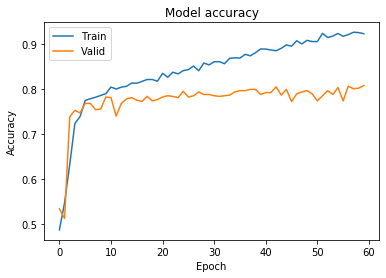

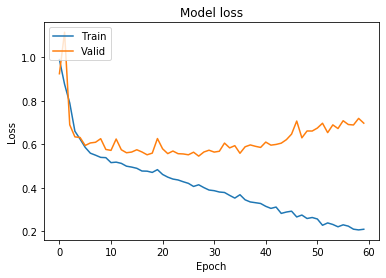

In [117]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

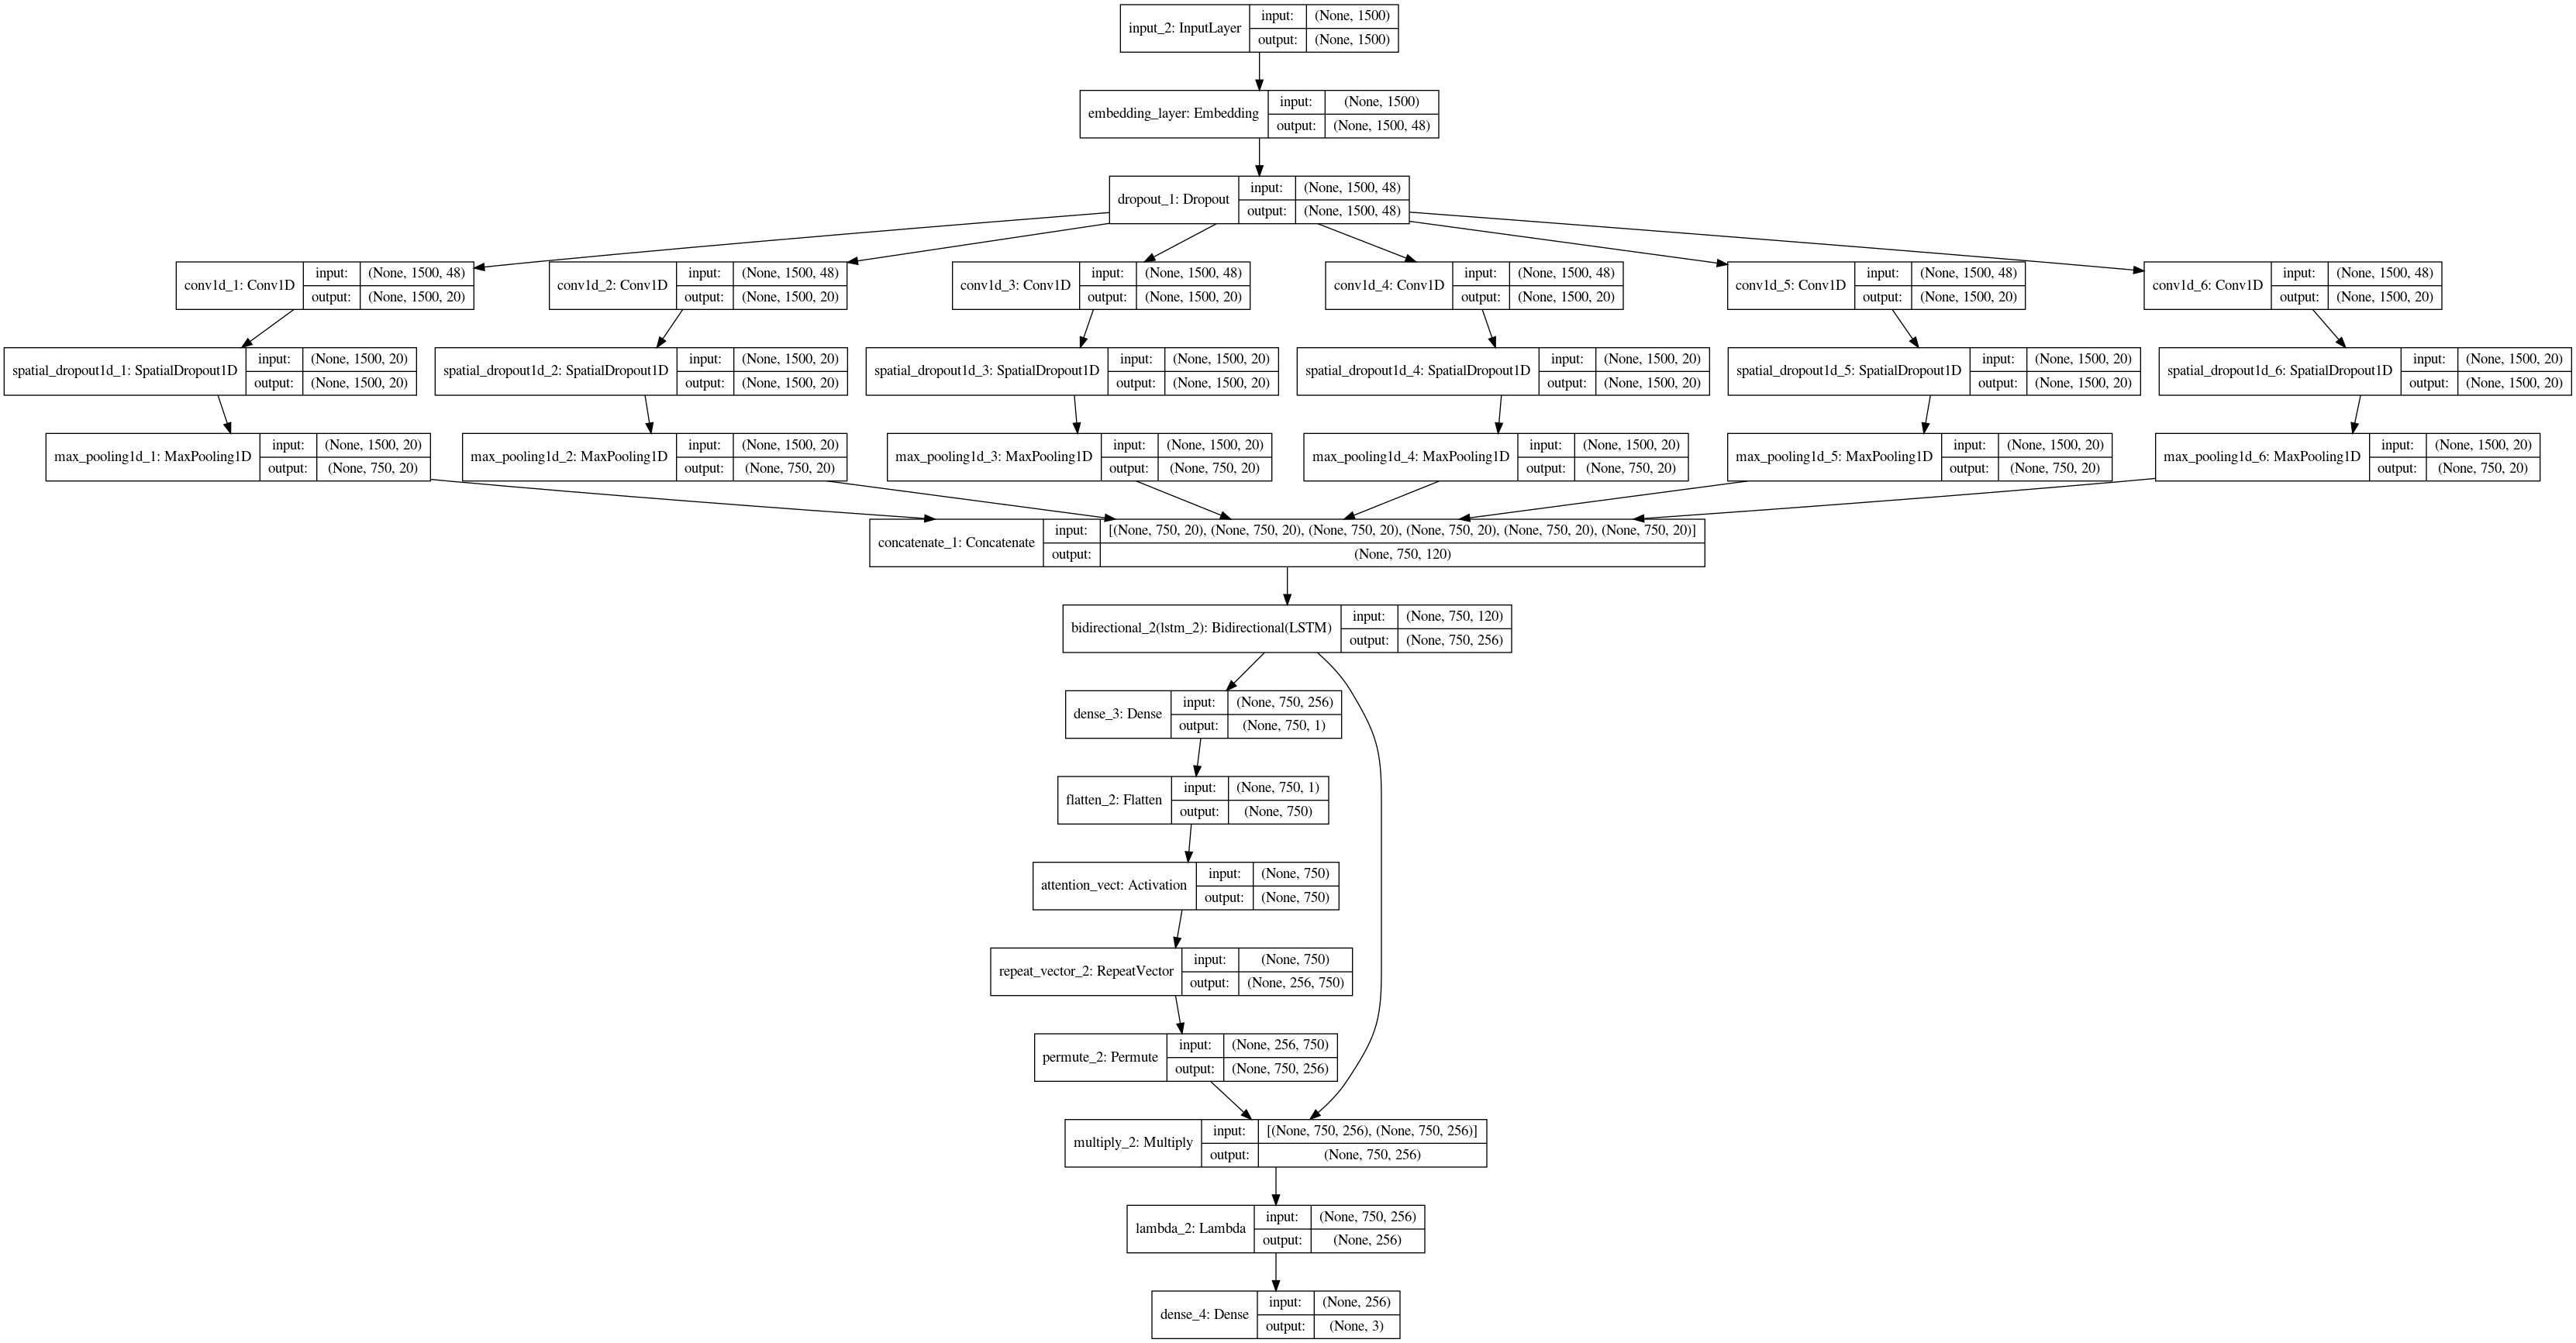

In [122]:
plot_model(model, to_file='models_attention/2/CNN_model_plot.png', show_shapes=True, show_layer_names=True)

In [168]:
model2 = load_model('models_attention/2/CNN_model_weights.hdf5')

In [160]:
model2.evaluate(x_valid_pad, y_valid_OH, verbose=0)

[0.5454519885803648, 0.794076144695282]

In [161]:
y_pred2 = model2.predict(x_valid_pad)
y_pred_indices2 = OH_to_label_indices(y_pred2)
y_pred_labels2 = indices_to_cat(y_pred_indices2)

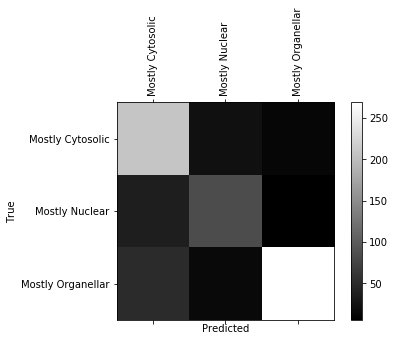

In [162]:
conf_mx2 = confusion_matrix(y_valid, y_pred_labels2, labels=cat)

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mx2, cmap=plt.cm.gray)
fig.colorbar(cax)
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.set_xticklabels([''] + cat,  rotation='vertical')
ax.set_yticklabels([''] + cat)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Attention Analysis 

In [169]:
model2 = Model(inputs=model2.input,
              outputs=[model2.output, model2.get_layer('attention_vect').output])
outputs2 = model2.predict(x_valid_pad)
model_outputs2 = outputs[0]
attention_outputs2 = outputs[1]
attention_outputs2.shape

(709, 750)

/home/julie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  import sys


Text(0, 0.5, 'Attention Distribution')

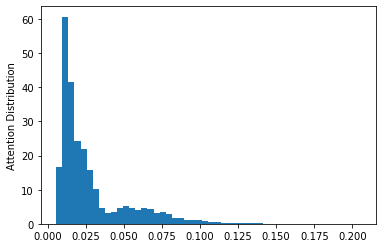

In [164]:
# Normalize attention values 
norm_attention2 = []
for seq in attention_outputs2:
    norm_attention2.append(seq / np.linalg.norm(seq))
    
attention_distrib2 = np.concatenate( norm_attention2, axis=0 )
plt.hist(attention_distrib2, normed=True, bins=50)
plt.ylabel('Attention Distribution')

In [ ]:
# So... it has nothing to do with the type of model.. since this is the same I used for 8 compartment analysis

In [165]:
# pool_size = 2
Attention_1500_2 = []
A = []
for x in norm_attention2:
    for i in range(len(x)):
        A.append(x[i])
        A.append(x[i])
    Attention_1500_2.append(np.array(A))
    A = []
    
# Number of highest values to select
nb_max = 50
max_att_indexes2 = []
for seq in Attention_1500_2:
    max_att_indexes2.append(np.sort(np.argpartition(seq, -nb_max)[-nb_max:]))
max_att_nopad2 = []    
for x in range(len(x_valid)):
    max_att_nopad2.append(max_att_indexes[x]-(1500-len(x_valid[x])))

In [166]:
X = 1

def color_charvals(s):
    r = 255-int(s.val*255)
    color = rgb_to_hex((255,255 , r))
    return 'background-color: %s' % color

max_ind = max_att_nopad2[X]
max_vect = np.zeros(len(x_valid[X]))
for val in max_ind:
    max_vect[val] = 1
# match each aa and attention
char_vals = [CharVal(c, v) for c, v in 
             zip(x_valid[X], max_vect)]

char_df = pd.DataFrame(char_vals).transpose()
# apply coloring values
char_df = char_df.style.applymap(color_charvals)
char_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451
0,M,A,A,P,S,A,G,S,W,S,T,F,Q,H,K,E,L,M,A,A,D,R,G,R,R,I,L,G,V,C,G,M,H,P,H,H,Q,E,T,L,K,K,N,R,V,V,L,A,K,Q,L,L,L,S,E,L,L,E,H,L,L,E,K,D,I,I,T,L,E,M,R,E,L,I,Q,A,K,V,G,S,F,S,Q,N,V,E,L,L,N,L,L,P,K,R,G,P,Q,A,F,D,A,F,C,E,A,L,R,E,T,K,Q,G,H,L,E,D,M,L,L,T,T,L,S,G,L,Q,H,V,L,P,P,L,S,C,D,Y,D,L,S,L,P,F,P,V,C,E,S,C,P,L,Y,K,K,L,R,L,S,T,D,T,V,E,H,S,L,D,N,K,D,G,P,V,C,L,Q,V,K,P,C,T,P,E,F,Y,Q,T,H,F,Q,L,A,Y,R,L,Q,S,R,P,R,G,L,A,L,V,L,S,N,V,H,F,T,G,E,K,E,L,E,F,R,S,G,G,D,V,D,H,S,T,L,V,T,L,F,K,L,L,G,Y,D,V,H,V,L,C,D,Q,T,A,Q,E,M,Q,E,K,L,Q,N,F,A,Q,L,P,A,H,R,V,T,D,S,C,I,V,A,L,L,S,H,G,V,E,G,A,I,Y,G,V,D,G,K,L,L,Q,L,Q,E,V,F,Q,L,F,D,N,A,N,C,P,S,L,Q,N,K,P,K,M,F,F,I,Q,A,C,R,G,D,E,T,D,R,G,V,D,Q,Q,D,G,K,N,H,A,G,S,P,G,C,E,E,S,D,A,G,K,E,K,L,P,K,M,R,L,P,T,R,S,D,M,I,C,G,Y,A,C,L,K,G,T,A,A,M,R,N,T,K,R,G,S,W,Y,I,E,A,L,A,Q,V,F,S,E,R,A,C,D,M,H,V,A,D,M,L,V,K,V,N,A,L,I,K,D,R,E,G,Y,A,P,G,T,E,F,H,R,C,K,E,M,S,E,Y,C,S,T,L,C,R,H,L,Y,L,F,P,G,H,P,P,T


In [ ]:
# Ok so with these model the accuracy is better but it didn't pick up the same regions at all (and for both X=3 is wrong)
# So maybe convolution or pool is not the best idea because I have not clue 

In [142]:
y_valid[1]

'Mostly Cytosolic'

In [143]:
y_pred_labels[1]

'Mostly Cytosolic'

### Test CNN model on test set

In [125]:
model.evaluate(x_test_pad, y_test_OH)

834/834 [==============================] - 23s 28ms/step


[0.4933147064859061, 0.8129496574401855]